In [2]:
# !pip install pymc

In [4]:
# ! pip install arviz

In [5]:
import os
import pickle
import pandas as pd
import numpy as  np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy.special as sp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

In [6]:
DATA_PATH='data/raw/'
df=pd.DataFrame()
for file in os.listdir(DATA_PATH):
    df_=pd.read_csv(f'{DATA_PATH}{file}')
    df=pd.concat([df, df_])
df.shape

(180524, 13)

In [7]:
df.head(10)

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
0,fb6f44a4e71821f2,2023-01,Valga,B,101,osaühing Kursus & Ko,E,bf2b7218d36e2a3d,MITTE_SOORITATUD,28.0,NaN,LIIKLUSOHUTUS|TEELPUSIMINE,NaN
1,82ed52e5990f8204,2023-01,Jõgeva,B,101,OÜ AUTOSÕIT,E,844452b4e4bac2ef,SOORITATUD,44.0,NaN,NaN,NaN
2,e72eeaf255d74785,2023-01,Narva,B,101|78,OSAÜHING ERMAN AUTOKOOL,E,d67d168bc8d04278,SOORITATUD,45.0,NaN,NaN,NaN
3,d0dd38daf0397c9d,2023-01,Valga,B,101,osaühing Kursus & Ko,J,bf2b7218d36e2a3d,MITTE_SOORITATUD,33.0,NaN,LIIKLUSOHUTUS,NaN
4,655194a10a21cd56,2023-01,Paide,B,101|78,Autokool Drive OÜ,E,f6097462dafbd97c,MITTE_SOORITATUD,18.0,NaN,PARKIMINE_MANOOVRIGA,EBAPIISAV_ETTEVALMISTUS|PARKIMINE_MARGISEL
5,761396cbfe80ec42,2023-01,Valga,B,101,osaühing Kursus & Ko,E,faeaf99580d6be30,SOORITATUD,42.0,NaN,NaN,NaN
6,de824d8083a1d269,2023-01,Rapla,B,101,Silver Autokool OÜ,E,4b9e369e12d8f969,SOORITATUD,49.0,NaN,NaN,NaN
7,44e0c0d162afebb0,2023-01,Narva,B,101,Osaühing STALIKA-VEOD,E,166c8268fe1b2ec1,SOORITATUD,41.0,NaN,NaN,NaN
8,808f4666542a6bc8,2023-01,Narva,B,101,Mittetulundusühing Autobis,E,166c8268fe1b2ec1,MITTE_SOORITATUD,47.0,NaN,LIIKLUSOHUTUS|PARKIMINE_MANOOVRIGA,OHUSTAMINE
9,cdc8a8cc2ddeca47,2023-01,Tartu,B,101|78,ROPKA ERAKOOL OÜ,NaN,c68c6310b2fe1124,EI_ILMUNUD_KOHALE,NaN,EI_ILMUNUD,NaN,NaN


In [8]:
df.describe(include='all')

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
count,180524,180524,180524,180524,129745,170298,175589,180524,180524,175214.000000,5320,77419,18738
unique,91167,47,17,14,11,366,2,59,4,NaN,7,2726,418
top,2a1562b30ea0f71a,2022-05,Tallinn,B,101,OÜ AUTOSÕIT,E,bf2b7218d36e2a3d,SOORITATUD,NaN,EI_ILMUNUD,LIIKLUSOHUTUS,AJA_YLETAMINE
freq,23,4792,68889,128633,96651,18021,165004,5320,97720,NaN,3275,11518,2724
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.991182,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.175641,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,NaN


## cols2keep

In [9]:
df_b=df[(df.KATEGOORIA=='B')&(df.SEISUND.isin(['MITTE_SOORITATUD', 'SOORITATUD']))]
df_b.shape

(124702, 13)

In [10]:
COLS2KEEP=['KUUPAEV', 'BYROO', 'ERITINGIMUSED','VIIMANE_AUTOKOOL','SOIDUOPETAJA_KAASAS', 'EKSAMINEERIJA', 'SEISUND']

In [11]:
df_b_sub=df_b[COLS2KEEP]

In [12]:
df_b_sub.head(10)

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
0,2023-01,Valga,101,osaühing Kursus & Ko,E,bf2b7218d36e2a3d,MITTE_SOORITATUD
1,2023-01,Jõgeva,101,OÜ AUTOSÕIT,E,844452b4e4bac2ef,SOORITATUD
2,2023-01,Narva,101|78,OSAÜHING ERMAN AUTOKOOL,E,d67d168bc8d04278,SOORITATUD
3,2023-01,Valga,101,osaühing Kursus & Ko,J,bf2b7218d36e2a3d,MITTE_SOORITATUD
4,2023-01,Paide,101|78,Autokool Drive OÜ,E,f6097462dafbd97c,MITTE_SOORITATUD
5,2023-01,Valga,101,osaühing Kursus & Ko,E,faeaf99580d6be30,SOORITATUD
6,2023-01,Rapla,101,Silver Autokool OÜ,E,4b9e369e12d8f969,SOORITATUD
7,2023-01,Narva,101,Osaühing STALIKA-VEOD,E,166c8268fe1b2ec1,SOORITATUD
8,2023-01,Narva,101,Mittetulundusühing Autobis,E,166c8268fe1b2ec1,MITTE_SOORITATUD
10,2023-01,Valga,101,OÜ AUTOSÕIT,E,ae264be409f2ca9f,SOORITATUD


In [13]:
# df_b_sub.head(10).to_dict()

In [14]:
df_b_sub.describe(include='all')

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
count,124702,124702,120919,120021,124702,124702,124702
unique,47,17,7,353,2,58,2
top,2022-03,Tallinn,101,OÜ AUTOSÕIT,E,c6d0f1ea0c1f7aec,MITTE_SOORITATUD
freq,3389,47397,91516,12700,115230,5024,64273


In [15]:
df_b_sub.SEISUND.value_counts()

SEISUND
MITTE_SOORITATUD    64273
SOORITATUD          60429
Name: count, dtype: int64

In [16]:
df_b[df_b.SEISUND=='KATKESTATUD']

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD


## Recode y

In [17]:
df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})

/tmp/ipykernel_87/645445151.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})
/tmp/ipykernel_87/645445151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})


In [18]:
epsilon = 1e-6  # small constant
df_b_sub['y_transformed'] =df_b_sub['y']* (1 - 2*epsilon) + epsilon

/tmp/ipykernel_87/4272676741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['y_transformed'] =df_b_sub['y']* (1 - 2*epsilon) + epsilon


## Extract time variables

In [19]:
df_b_sub['year']=pd.to_datetime(df_b_sub.KUUPAEV).dt.year
df_b_sub['week']=pd.to_datetime(df_b_sub.KUUPAEV).dt.isocalendar().week
df_b_sub['month']=pd.to_datetime(df_b_sub.KUUPAEV).dt.month
df_b_sub['dow']=pd.to_datetime(df_b_sub.KUUPAEV).dt.dayofweek

/tmp/ipykernel_87/1433284352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['year']=pd.to_datetime(df_b_sub.KUUPAEV).dt.year
/tmp/ipykernel_87/1433284352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['week']=pd.to_datetime(df_b_sub.KUUPAEV).dt.isocalendar().week
/tmp/ipykernel_87/1433284352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [20]:
# Now create the cyclical features for month
df_b_sub['month_sin'] = np.sin(2 * np.pi * df_b_sub['month']/12)
df_b_sub['month_cos'] = np.cos(2 * np.pi * df_b_sub['month']/12)

# Let's look at the first few rows to see the result
df_b_sub[['KUUPAEV', 'month', 'month_sin', 'month_cos']].head()

,KUUPAEV,month,month_sin,month_cos
0,2023-01,1,0.5,0.866025
1,2023-01,1,0.5,0.866025
2,2023-01,1,0.5,0.866025
3,2023-01,1,0.5,0.866025
4,2023-01,1,0.5,0.866025


In [21]:
# Create cyclical features for week
df_b_sub['week_sin'] = np.sin(2 * np.pi * df_b_sub['week']/52)
df_b_sub['week_cos'] = np.cos(2 * np.pi * df_b_sub['week']/52)

In [22]:
# Create cyclical features for week
df_b_sub['day_sin'] = np.sin(2 * np.pi * df_b_sub['dow']/7)
df_b_sub['day_cos'] = np.cos(2 * np.pi * df_b_sub['dow']/7)

<Axes: xlabel='week'>

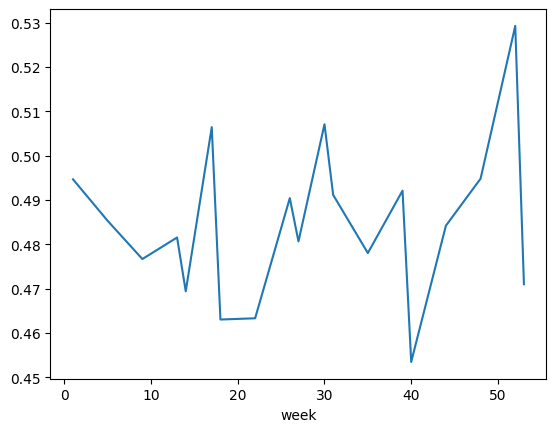

In [23]:
df_b_sub.groupby(['week'])['y'].mean().plot()

<Axes: xlabel='month'>

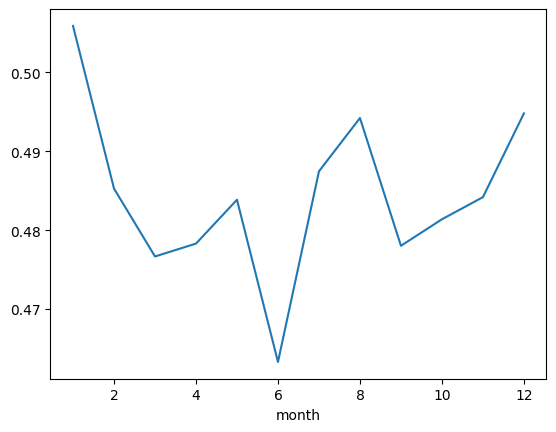

In [24]:
df_b_sub.groupby(['month'])['y'].mean().plot()

<Axes: xlabel='week'>

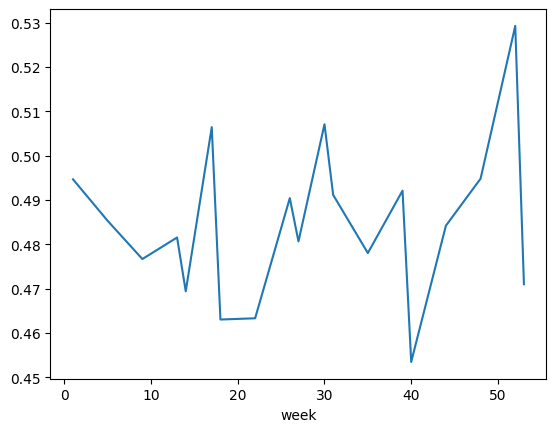

In [25]:
df_b_sub.groupby(['week'])['y'].mean().plot()

<Axes: xlabel='dow'>

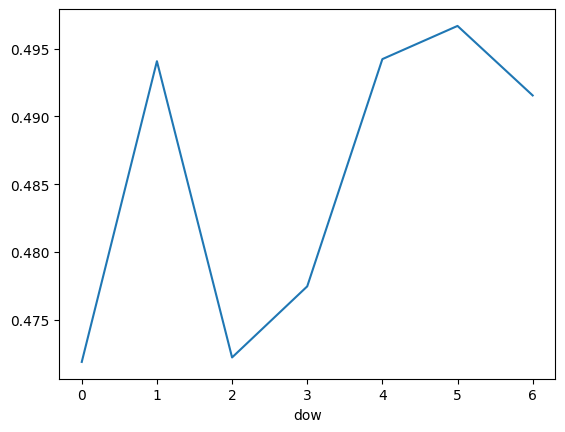

In [26]:
df_b_sub.groupby(['dow'])['y'].mean().plot()

In [27]:
df_b_sub.groupby(['year'])['y'].mean()

year
2021    0.477491
2022    0.504322
2023    0.478739
2024    0.475784
Name: y, dtype: float64

In [28]:
df_b_sub.dow.value_counts()

dow
0    22264
4    21055
2    18282
3    17723
1    17384
5    14150
6    13844
Name: count, dtype: int64

In [29]:
time_features = ['month_sin', 'month_cos']
df_b_sub[time_features] = (df_b_sub[time_features] - df_b_sub[time_features].mean()) / df_b_sub[time_features].std()

y_transformed                 
              mean       std  count
week                               
1         0.494645  0.500054   2988
5         0.485275  0.499807  10085
9         0.476670  0.499475  12109
13        0.481532  0.499692   7337
14        0.469395  0.499155   2663
17        0.506415  0.500006   5144
18        0.463030  0.498675   5572
22        0.463310  0.498680   8599
26        0.490411  0.499944   6674
27        0.480650  0.499711   2894
30        0.507070  0.500071   2051
31        0.491136  0.499950   8574
35        0.478023  0.499538  11148
39        0.492086  0.499969   7708
40        0.453469  0.497913   2955
44        0.484187  0.499769  12268
48        0.494798  0.500008   7017
52        0.529243  0.499185   5916
53        0.471000  0.499241   3000

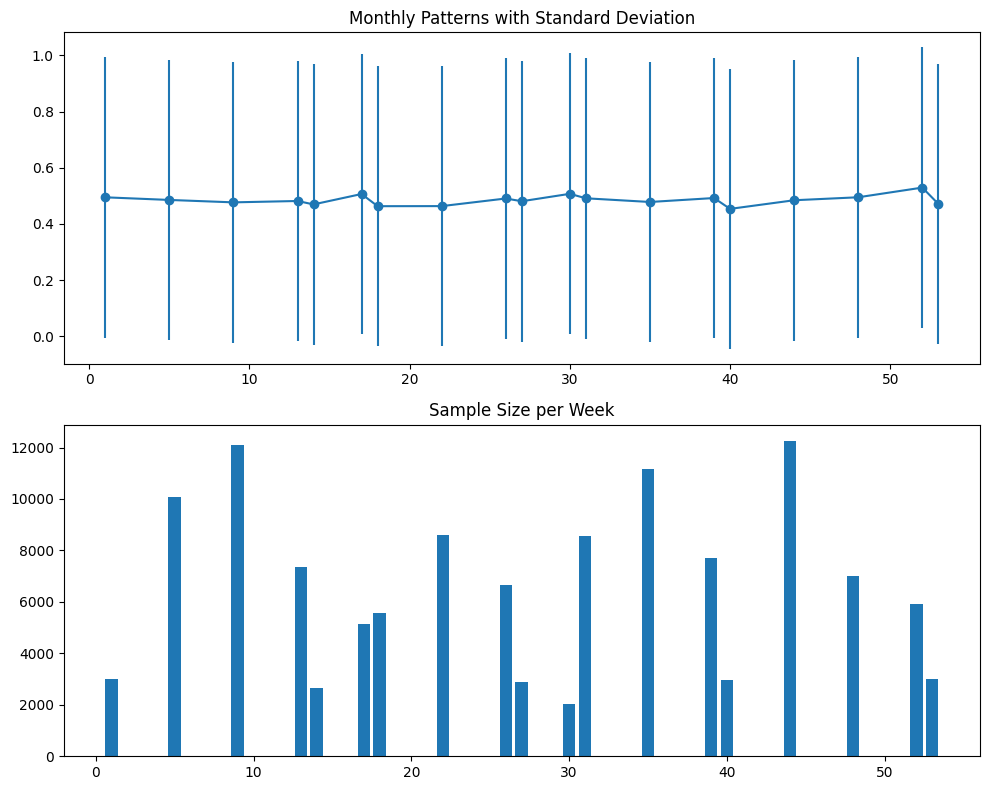

In [30]:
def analyze_time_patterns():
    # Get monthly averages and counts
    monthly_stats = df_b_sub.groupby(pd.to_datetime(df_b_sub['KUUPAEV']).dt.isocalendar().week).agg({
        'y_transformed': ['mean', 'std', 'count']
    })
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot means with error bars
    ax1.errorbar(monthly_stats.index, 
                monthly_stats[('y_transformed', 'mean')],
                yerr=monthly_stats[('y_transformed', 'std')],
                fmt='o-')
    ax1.set_title('Monthly Patterns with Standard Deviation')
    
    # Plot sample sizes
    ax2.bar(monthly_stats.index, monthly_stats[('y_transformed', 'count')])
    ax2.set_title('Sample Size per Week')
    
    plt.tight_layout()
    return monthly_stats

analyze_time_patterns()

## Make year feature

In [31]:
# Center the years (subtract mean) to make interpretation easier
# First, create year index mapping
year_to_idx = {year: idx for idx, year in enumerate(df_b_sub['year'].unique())}
idx_to_year={v:k for k,v in year_to_idx.items()}
n_years = len(year_to_idx)

# Add year index to dataframe
df_b_sub['year_idx'] = df_b_sub['year'].map(year_to_idx)

## Day of week feature

In [32]:
dow_to_idx = {year: idx for idx, year in enumerate(df_b_sub['dow'].unique())}
idx_to_dow={v:k for k,v in dow_to_idx.items()}
n_dows = len(dow_to_idx)

# Add year index to dataframe
df_b_sub['dow_idx'] = df_b_sub['dow'].map(dow_to_idx)

## Recode others

In [33]:
# Fill missing values with 'UNKNOWN'
df_b_sub['VIIMANE_AUTOKOOL'] = df_b_sub['VIIMANE_AUTOKOOL'].fillna('UNKNOWN')

count_examiner=df_b_sub['EKSAMINEERIJA'].str.lower().value_counts()
examiners2keep=count_examiner[count_examiner>20].index
df_b_sub['EKSAMINEERIJA_CLEAN'] = np.where(df_b_sub['EKSAMINEERIJA'].isin(examiners2keep), df_b_sub['EKSAMINEERIJA'], 'grupp')
# Create numeric indices for categorical variables
examiner_to_idx = {examiner: idx for idx, examiner in enumerate(df_b_sub['EKSAMINEERIJA_CLEAN'].unique())}
idx_to_examiner={v:k for k,v in examiner_to_idx.items()}
school_to_idx = {school: idx for idx, school in enumerate(df_b_sub['VIIMANE_AUTOKOOL'].str.lower().unique())}
idx_to_school={v:k for k,v in school_to_idx.items()}

# Convert categories to indices
df_b_sub['examiner_idx'] = df_b_sub['EKSAMINEERIJA_CLEAN'].map(examiner_to_idx)
df_b_sub['school_idx'] = df_b_sub['VIIMANE_AUTOKOOL'].str.lower().map(school_to_idx)

# Convert target to binary
df_b_sub['passed'] = (df_b_sub['SEISUND'] == 'SOORITATUD').astype(int)

In [34]:
count_schools=df_b_sub['VIIMANE_AUTOKOOL'].str.lower().value_counts()
count_schools[count_schools>20]

VIIMANE_AUTOKOOL
oü autosõit                              12700
unknown                                   4681
osaühing aide autokool                    4663
atlanta autokool oü                       4051
aktsiaselts odium                         3591
                                         ...  
vana-vigala tehnika- ja teeninduskool       23
trestem oü                                  23
osaühing kalju autokool                     22
a-autom, oü                                 21
oü horizontrans                             21
Name: count, Length: 227, dtype: int64

In [35]:
#count_examiner#[count_examiner>20]

In [36]:
# First create index mapping for BYROO
byroo_to_idx = {byroo: idx for idx, byroo in enumerate(df_b_sub['BYROO'].unique())}
idx_to_byroo={v:k for k,v in byroo_to_idx.items()}

n_byroos = len(byroo_to_idx)

# Convert BYROO to indices
df_b_sub['byroo_idx'] = df_b_sub['BYROO'].map(byroo_to_idx)

In [37]:
# Get dimensions for our hierarchical components
n_examiners = len(examiner_to_idx)
n_schools = len(school_to_idx)

In [38]:
n_examiners

56

## Model

In [48]:
# Create the model
with pm.Model() as model:
    # Global intercept
    #intercept = pm.Normal('intercept', mu=0, sigma=0.1)
    intercept_raw = pm.Normal('intercept_raw', mu=0, sigma=1)
    intercept_sigma = pm.HalfStudentT('intercept_sigma', nu=3, sigma=0.05)
    intercept = pm.Deterministic('intercept', intercept_raw * intercept_sigma)
    
    # Hierarchical priors for examiners and schools
    examiner_sigma = pm.HalfCauchy('examiner_sigma', beta=0.1)
    examiner_raw = pm.Normal('examiner_raw', mu=0, sigma=1, shape=n_examiners)
    examiner_effects = pm.Deterministic('examiner_effects', examiner_raw * examiner_sigma)
    
    # Non-centered parameterization for schools
    school_sigma = pm.HalfStudentT('school_sigma', nu=3, sigma=0.5)
    school_raw = pm.Normal('school_raw', mu=0, sigma=1, shape=n_schools)
    school_effects = pm.Deterministic('school_effects', school_raw * school_sigma)
    
    # Non-centered parameterization for byroo
    byroo_sigma = pm.HalfStudentT('byroo_sigma', nu=3, sigma=0.1)
    byroo_raw = pm.Normal('byroo_raw', mu=0, sigma=1, shape=n_byroos)
    byroo_effects = pm.Deterministic('byroo_effects', byroo_raw * byroo_sigma)
     
    # Combine all predictors
    logit = (intercept + 
             examiner_effects[df_b_sub['examiner_idx']] +
             school_effects[df_b_sub['school_idx']] +
             byroo_effects[df_b_sub['byroo_idx']])
            
        
     # Transform mu to be between 0 and 1
    mu_bounded = pm.math.invlogit(logit)
    
    # Use transformed data with Beta likelihood
    alpha = pm.HalfNormal('alpha', sigma=1)
    y = pm.Beta('y', 
                    alpha=mu_bounded*alpha, 
                    beta=(1-mu_bounded)*alpha, 
                    observed=df_b_sub['y_transformed'])

## Sample

In [49]:
with model:
    # Initialize the sampler
    # Using NUTS (No U-Turn Sampler) which is good for continuous parameters
    trace = pm.sample(
        draws=4000,          # Number of samples to draw
        tune=4000,           # Number of tuning steps
        chains=4,            # Number of chains to run
        init='advi',  
        return_inferencedata=True,
        target_accept=0.95    # Target acceptance rate
    )

Initializing NUTS using advi...


Output()

Convergence achieved at 30800
Interrupted at 30,799 [15%]: Average Loss = -1.1422e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_raw, intercept_sigma, examiner_sigma, examiner_raw, school_sigma, school_raw, byroo_sigma, byroo_raw, alpha]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 7431 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Diagnostic

In [41]:
# Check basic convergence statistics
df_summary=az.summary(trace)

In [42]:
df_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_raw,-0.053,0.812,-1.619,1.523,0.033,0.023,623.0,1333.0,1.00
examiner_raw[0],1.330,0.226,0.916,1.766,0.010,0.007,524.0,1564.0,1.00
examiner_raw[1],2.274,0.263,1.782,2.760,0.015,0.011,306.0,944.0,1.01
examiner_raw[2],-0.506,0.183,-0.848,-0.162,0.007,0.005,698.0,1971.0,1.01
examiner_raw[3],-1.292,0.180,-1.628,-0.952,0.008,0.006,493.0,1472.0,1.00
...,...,...,...,...,...,...,...,...,...
byroo_effects[12],-0.033,0.041,-0.110,0.044,0.001,0.001,1599.0,3591.0,1.00
byroo_effects[13],-0.043,0.046,-0.126,0.047,0.001,0.001,1667.0,3317.0,1.00
byroo_effects[14],-0.109,0.041,-0.185,-0.033,0.001,0.001,961.0,2441.0,1.00
byroo_effects[15],0.068,0.057,-0.035,0.180,0.001,0.001,4091.0,6029.0,1.00


In [43]:
df_summary[df_summary.r_hat>1.05].shape

(0, 9)

In [44]:
df_summary[df_summary.r_hat>1.01].shape

(0, 9)


Model Parameter Summary:


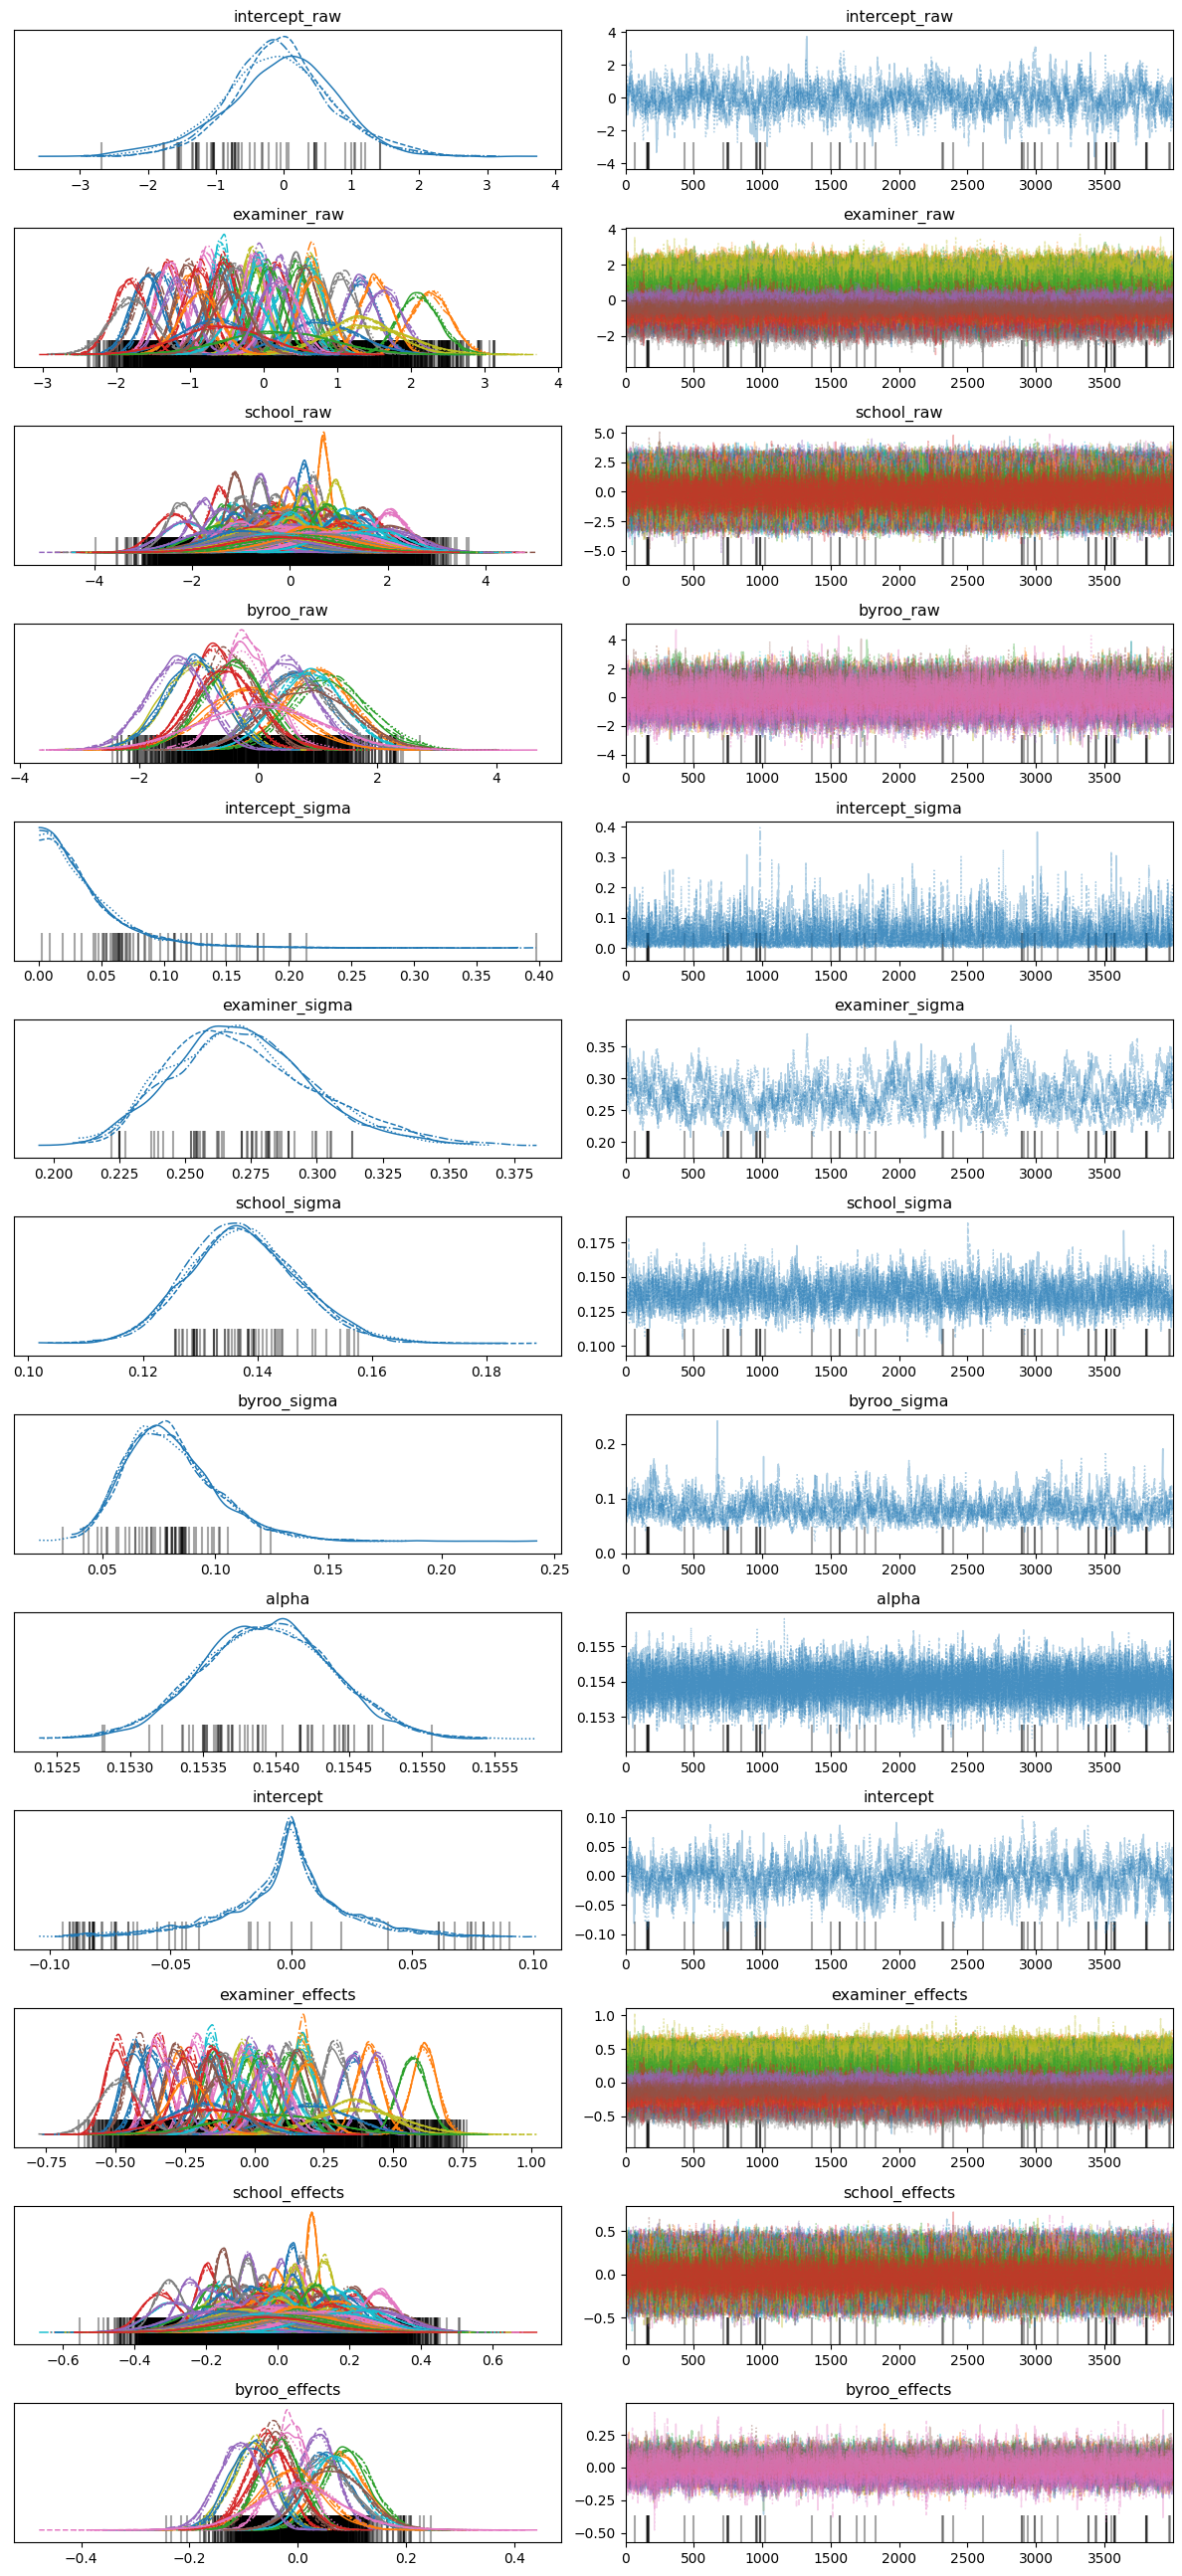

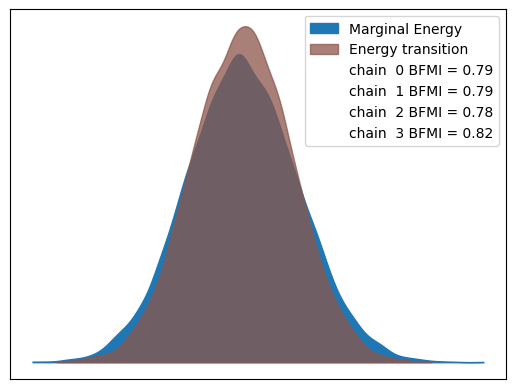


Number of divergent samples:
<xarray.DataArray 'diverging' ()> Size: 8B
array(62)


In [45]:
# Basic convergence diagnostics
print("\nModel Parameter Summary:")
summary = az.summary(trace, kind='diagnostics')

# Plot trace diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Plot energy diagnostics
az.plot_energy(trace)
plt.show()

# Check for divergences
print("\nNumber of divergent samples:")
print(trace.sample_stats.diverging.sum())

In [46]:
df_summary[df_summary.r_hat>1.01]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


## Save trace

In [56]:
# Save as netCDF file (recommended)
trace.to_netcdf("models/soidueksam_b_kat_multiyear_v2.nc")

# Or save as pickle file

with open('models/soidueksam_b_kat_multiyear_v2.pkl', 'wb') as buff:
    pickle.dump(trace, buff)

## Load trace

In [39]:
trace = az.from_netcdf("models/soidueksam_b_kat_multiyear_v2.nc")

## overall exam success

In [47]:
def get_average_success_probability(trace):
    # Get intercept (baseline)
    intercept = trace.posterior['intercept'].values
    
    # Convert to probability using inverse logit
    baseline_prob = 1 / (1 + np.exp(-intercept))
    
    # Calculate summary statistics
    results = {
        'mean': np.mean(baseline_prob),
        'std': np.std(baseline_prob),
        'lower_ci': np.percentile(baseline_prob, 2.5),
        'upper_ci': np.percentile(baseline_prob, 97.5)
    }
    
    print("Overall Success Probability:")
    print(f"Mean: {results['mean']:.3f}")
    print(f"95% CI: [{results['lower_ci']:.3f}, {results['upper_ci']:.3f}]")
    
    return results

average_prob = get_average_success_probability(trace)
average_prob

Overall Success Probability:
Mean: 0.499
95% CI: [0.485, 0.512]


{'mean': 0.4994130681336378,
 'std': 0.006267762731425692,
 'lower_ci': 0.48505561381233514,
 'upper_ci': 0.512407981453416}

In [48]:
df_b_sub.y.mean()

0.48458725601834773

## Factors that contribute the most

<Figure size 1800x500 with 0 Axes>

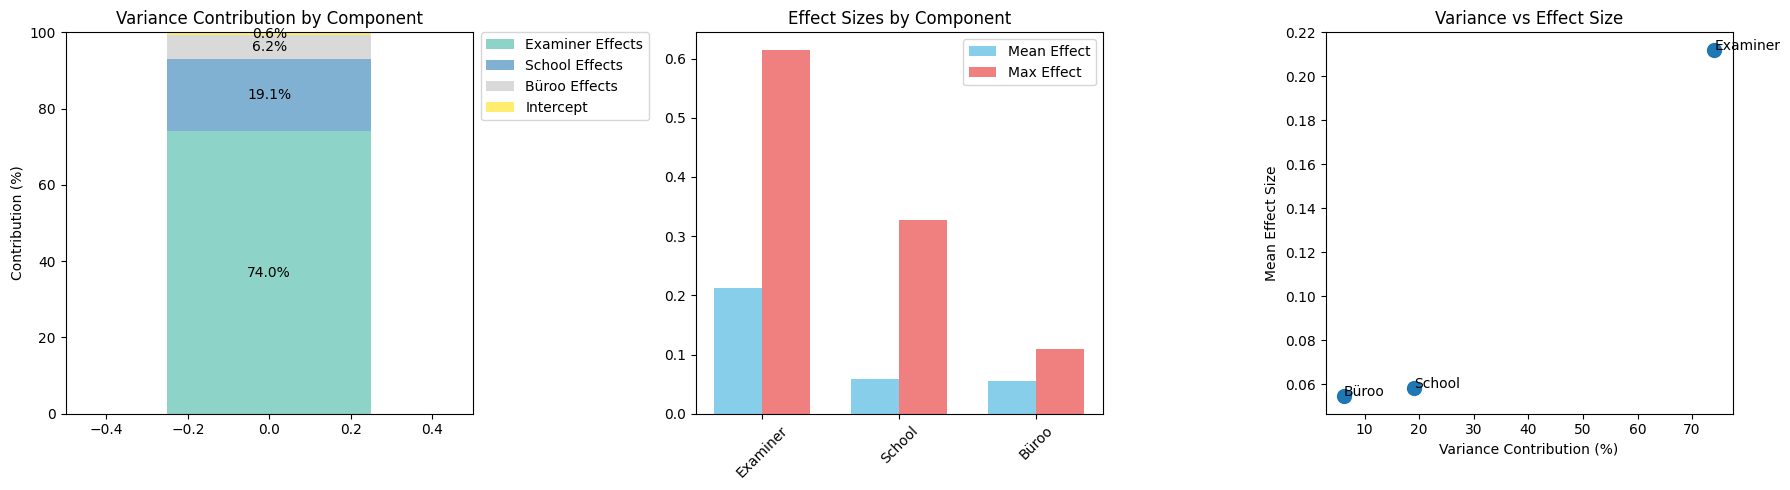

In [50]:
def analyze_component_contributions(trace):
    # Get components
    intercept_var = np.var(trace.posterior['intercept'].values)
    examiner_var = np.var(trace.posterior['examiner_effects'].values.reshape(-1))
    school_var = np.var(trace.posterior['school_effects'].values.reshape(-1))
    byroo_var = np.var(trace.posterior['byroo_effects'].values.reshape(-1))

    
    # Calculate total variance
    total_var = intercept_var + examiner_var + school_var + byroo_var 
    
    # Calculate proportions
    contributions = pd.Series({
        'Intercept': intercept_var/total_var,
        'Examiner Effects': examiner_var/total_var,
        'School Effects': school_var/total_var,
        'Büroo Effects': byroo_var/total_var
    })
    
    return contributions * 100  # Convert to percentages

def analyze_effect_sizes(trace, return_df=False):
    # Get absolute mean effects
    examiner_effects = np.abs(np.mean(trace.posterior['examiner_effects'].values, axis=(0,1)))
    school_effects = np.abs(np.mean(trace.posterior['school_effects'].values, axis=(0,1)))
    byroo_effects = np.abs(np.mean(trace.posterior['byroo_effects'].values, axis=(0,1)))

    result={
        'Examiner': {'mean': examiner_effects.mean(), 'max': examiner_effects.max()},
        'School': {'mean': school_effects.mean(), 'max': school_effects.max()},
        'Büroo': {'mean': byroo_effects.mean(), 'max': byroo_effects.max()}
    }
    
    if return_df:
        return pd.DataFrame(result)
    return result


def plot_model_contributions(trace):
    # Get contributions
    contributions = analyze_component_contributions(trace)
    contributions=contributions.sort_values(ascending=False)
    
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # 1. Stacked Bar Plot
    plt.subplot(131)
    colors = plt.cm.Set3(np.linspace(0, 1, len(contributions)))
    
    # Create bars one by one to properly set up legend
    bottom = 0
    bars = []
    for i, (name, value) in enumerate(contributions.items()):
        bar = plt.bar(0, value, bottom=bottom, color=colors[i], width=0.5, label=name)
        plt.text(0, bottom + value/2, f'{value:.1f}%', ha='center', va='center')
        bottom += value
        bars.append(bar)
    
    plt.xlim(-0.5, 0.5)
    plt.ylim(0, 100)
    plt.ylabel('Contribution (%)')
    plt.title('Variance Contribution by Component')
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.02, 1), 
              loc='upper left',
              borderaxespad=0)
    
    # 2. Bar Plot with Effect Sizes
    effect_sizes = analyze_effect_sizes(trace)
    plt.subplot(132)
    components = list(effect_sizes.keys())
    means = [d['mean'] for d in effect_sizes.values()]
    maxes = [d['max'] for d in effect_sizes.values()]
    
    x = np.arange(len(components))
    width = 0.35
    
    plt.bar(x - width/2, means, width, label='Mean Effect', color='skyblue')
    plt.bar(x + width/2, maxes, width, label='Max Effect', color='lightcoral')
    plt.xticks(x, components, rotation=45)
    plt.title('Effect Sizes by Component')
    plt.legend()
    
    # 3. Scatter Plot: Variance vs Mean Effect
    plt.subplot(133)
    # Map component names to contribution names
    name_map = {
        'Examiner': 'Examiner Effects',
        'Büroo': 'Büroo Effects',
        'School': 'School Effects',
        'Month': 'Month Effects'
        
    }
    matched_contributions = [contributions[name_map[c]] for c in components]
    
    plt.scatter(matched_contributions, means, s=100)
    for i, txt in enumerate(components):
        plt.annotate(txt, (matched_contributions[i], means[i]))
    plt.xlabel('Variance Contribution (%)')
    plt.ylabel('Mean Effect Size')
    plt.title('Variance vs Effect Size')
    
    plt.tight_layout()
    plt.show()
    
plot_model_contributions(trace)

## Visualize effect contributions


Probability changes:
Intercept: -0.001
Examiner: 0.089
School: -0.003
Bureau: 0.012

Final probability: 0.597
Actual outcome: 0.000


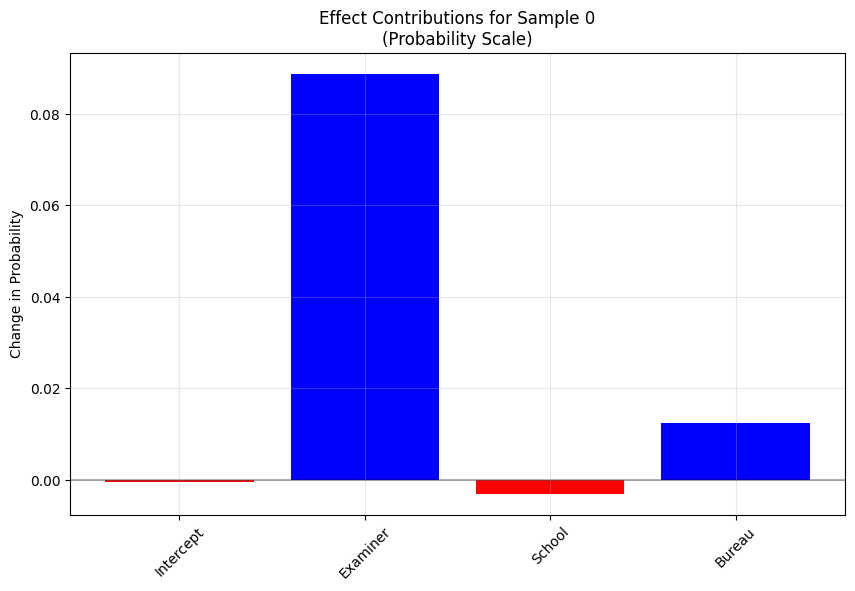

In [52]:
# Get posterior means
examiner_effects_mean = trace.posterior['examiner_effects'].mean(dim=('chain', 'draw'))
school_effects_mean = trace.posterior['school_effects'].mean(dim=('chain', 'draw'))
byroo_effects_mean = trace.posterior['byroo_effects'].mean(dim=('chain', 'draw'))
intercept_mean = float(trace.posterior['intercept'].mean())

def plot_effects_breakdown_prob(sample_idx):
    # Get base effects (logit scale)
    effects = {
        'Intercept': intercept_mean,
        'Examiner': examiner_effects_mean[df_b_sub['examiner_idx'].iloc[sample_idx]],
        'School': school_effects_mean[df_b_sub['school_idx'].iloc[sample_idx]],
        'Bureau': byroo_effects_mean[df_b_sub['byroo_idx'].iloc[sample_idx]]
    }
    
    # Convert to probability changes
    prob_changes = {}
    cumulative = 0
    for k, v in effects.items():
        prev_prob = sp.expit(cumulative)
        cumulative += v
        new_prob = sp.expit(cumulative)
        prob_changes[k] = new_prob - prev_prob
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['blue' if v >= 0 else 'red' for v in prob_changes.values()]
    plt.bar(prob_changes.keys(), prob_changes.values(), color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Effect Contributions for Sample {sample_idx}\n(Probability Scale)')
    plt.ylabel('Change in Probability')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Print values
    print("\nProbability changes:")
    for k, v in prob_changes.items():
        print(f"{k}: {v:.3f}")
    print(f"\nFinal probability: {sp.expit(sum(effects.values())):.3f}")
    print(f"Actual outcome: {df_b_sub['y_transformed'].iloc[sample_idx]:.3f}")
    
plot_effects_breakdown_prob(0)


Probability changes:
Intercept: -0.001
Examiner: 0.149
School: 0.021
Bureau: 0.018

Final probability: 0.687
Actual outcome: 1.000


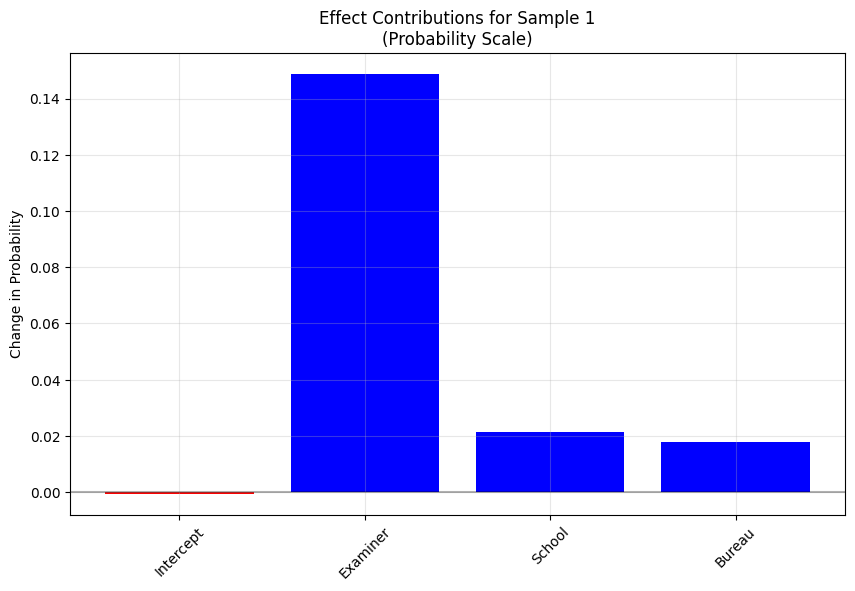

In [53]:
plot_effects_breakdown_prob(1)


Probability changes:
Intercept: -0.001
Examiner: -0.052
School: -0.021
Bureau: -0.004

Final probability: 0.423
Actual outcome: 1.000


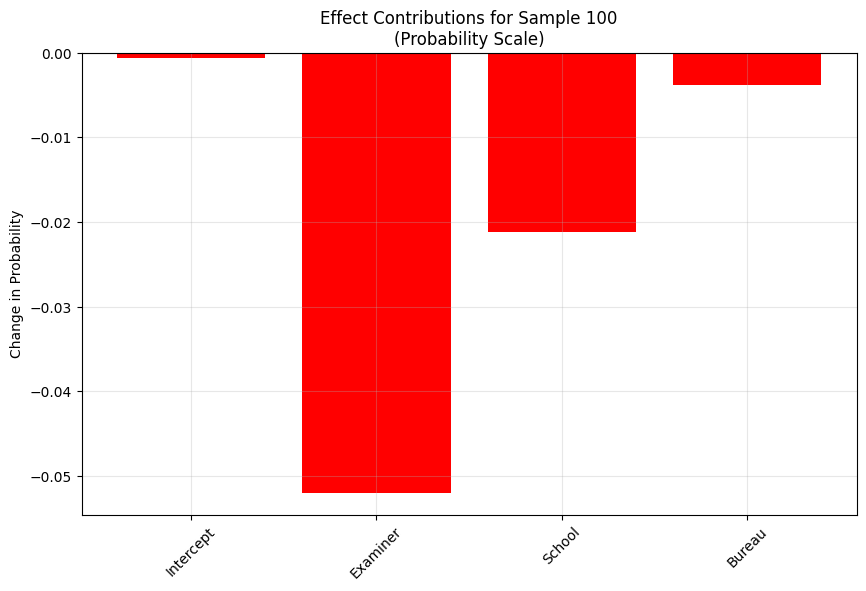

In [54]:
plot_effects_breakdown_prob(100)

## Examiner effects

Number of examiner_idx with significant positive effect: 17
Number of examiner_idx with significant negative effect: 20


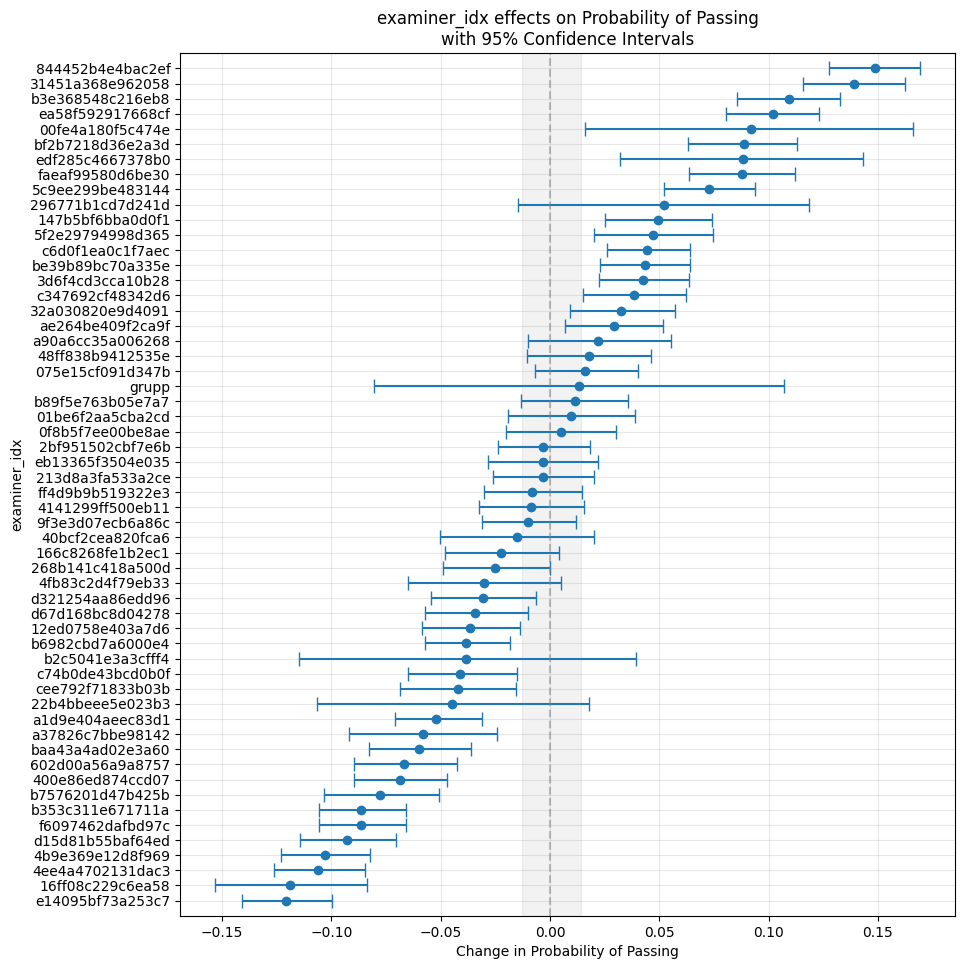

In [55]:
def plot_effects(y_labels_col='examiner_idx', effects_key='examiner_effects', only_significant=False,
                y_dict=None):
# Get all samples for examiner effects
    examiner_samples = trace.posterior[effects_key]
    
    # Get examiner IDs (assuming they're in the original order in df_b_sub)
    examiner_ids = df_b_sub[y_labels_col].unique()
    
    # Calculate mean and HDI for each examiner
    means = []
    hdis = []
    ids = []  # Store IDs in same order as effects
    labels=[]
    
    # Convert logit effects to probability changes
    base_prob = sp.expit(intercept_mean)
    
    for i in range(examiner_samples.shape[2]):
        effect_samples = examiner_samples[:, :, i].values.flatten()
        prob_changes = sp.expit(intercept_mean + effect_samples) - base_prob
        percentiles=np.percentile(prob_changes, [2.5, 97.5])
        if only_significant and ((percentiles[0]<0.0 and percentiles[1]<0.0) or (percentiles[0]>0.0 and percentiles[1]>0.0)):
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
        elif not only_significant:
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
    
    # Sort by mean effect
    sorted_indices = np.argsort(means)
    means = np.array(means)[sorted_indices]
    hdis = np.array(hdis)[sorted_indices]
    ids = np.array(ids)[sorted_indices]
    if len(labels)>0:
        labels = np.array(labels)[sorted_indices]
    
    # Calculate confidence interval for baseline probability
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    # Plot
    plt.figure(figsize=(10, len(means)*0.2))
    
    # Add shaded confidence interval around zero
    plt.axvspan(-base_ci[1] + base_prob, -base_ci[0] + base_prob, 
                color='grey', alpha=0.1, label='Baseline CI')
    
    # Plot effects
    plt.errorbar(means, range(len(means)),
                xerr=[means - hdis[:, 0], hdis[:, 1] - means],
                fmt='o', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
       
    # Add examiner IDs to y-axis
    if y_dict is not None:
        plt.yticks(range(len(means)), labels)
    else:
        plt.yticks(range(len(means)), ids)
     # Adjust y-axis limits to remove extra margins
    plt.ylim(-1.0, len(means))  # This removes the extra space
    
    plt.ylabel(y_labels_col)
    plt.xlabel('Change in Probability of Passing')
    plt.title(f'{y_labels_col} effects on Probability of Passing\nwith 95% Confidence Intervals')
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print(f"Number of {y_labels_col} with significant positive effect: {sum(hdis[:, 0] > 0)}")
    print(f"Number of {y_labels_col} with significant negative effect: {sum(hdis[:, 1] < 0)}")
    
plot_effects(y_dict=idx_to_examiner)

## School effects

Number of school_idx with significant positive effect: 30
Number of school_idx with significant negative effect: 28


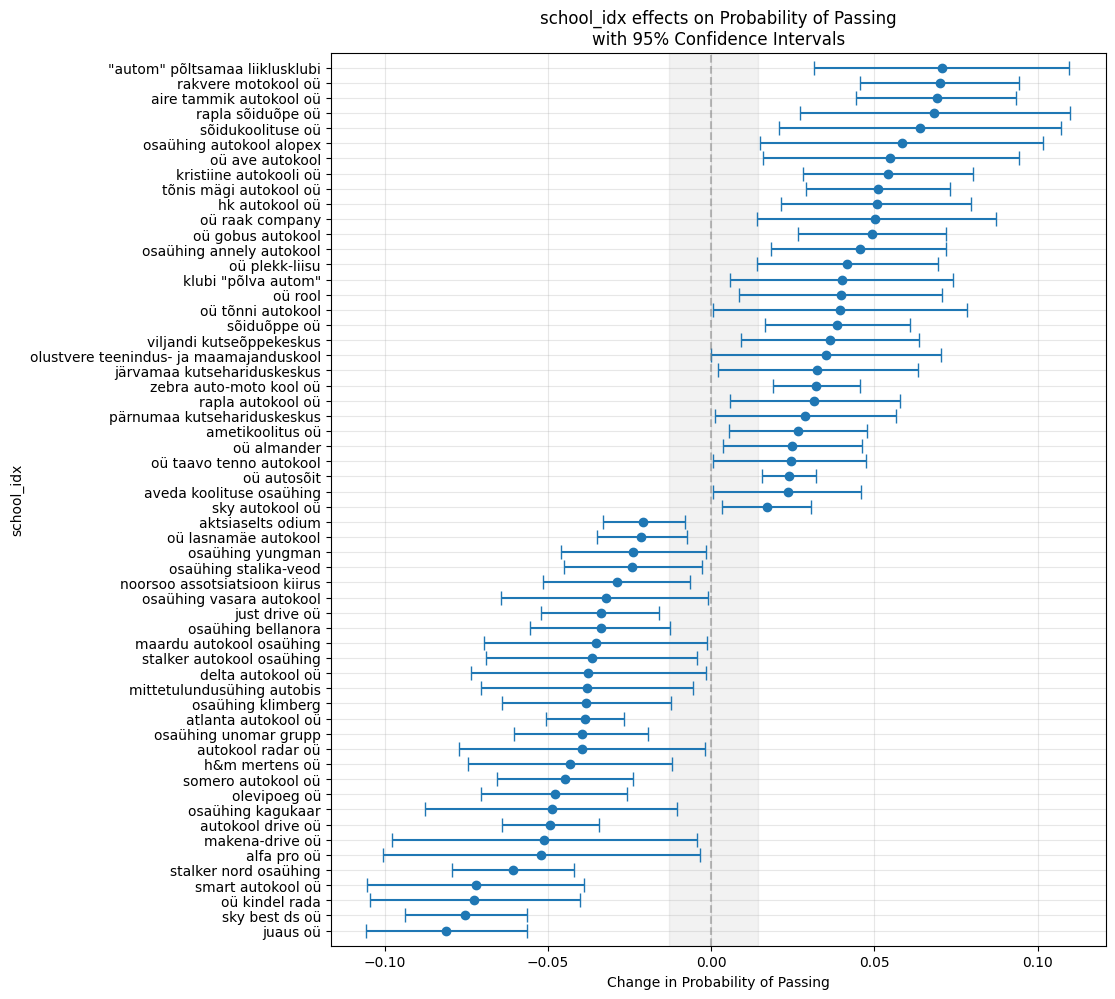

In [56]:
plot_effects(y_labels_col='school_idx', effects_key='school_effects', only_significant=True,
             y_dict=idx_to_school)

## Büroo effects

Number of byroo_idx with significant positive effect: 1
Number of byroo_idx with significant negative effect: 3


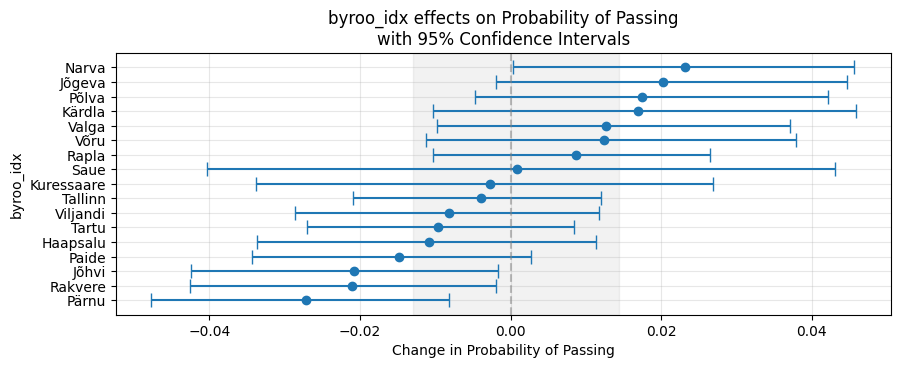

In [57]:
plot_effects(y_labels_col='byroo_idx', effects_key='byroo_effects', only_significant=False,
             y_dict=idx_to_byroo)

In [61]:
df_b_sub.VIIMANE_AUTOKOOL.value_counts()[:50]

VIIMANE_AUTOKOOL
OÜ AUTOSÕIT                                12700
UNKNOWN                                     4681
osaühing Aide Autokool                      4663
Atlanta Autokool OÜ                         4051
Aktsiaselts Odium                           3591
Sky Autokool OÜ                             3110
Zebra Auto-Moto kool OÜ                     3102
OÜ LASNAMÄE AUTOKOOL                        2906
Osaühing LRK Autokoolitus                   2839
Silver Autokool OÜ                          2579
VPK Koolitus OÜ                             2433
Autokool Drive OÜ                           2352
OÜ Taavo Tenno Autokool                     1891
osaühing RADIANT                            1869
Tugev Partner OÜ                            1731
Autom Tallinna Autokool OÜ                  1556
JUST DRIVE OÜ                               1458
Stalker Nord Osaühing                       1389
MMK Grupp OÜ                                1380
Osaühing STALIKA-VEOD                       1299
Osa

In [62]:
df_b_sub.VIIMANE_AUTOKOOL.nunique()

354

In [64]:
df_b_sub.VIIMANE_AUTOKOOL.str.lower().nunique()

354